In [152]:
import markovNetworkLearning as mnl
import pyAgrum as gum
import importlib
import plot
import matplotlib.pyplot as plt
from pathlib import Path
import time
import os
import pandas as pd
import numpy as np
import random
importlib.reload(plot)
import pyAgrum.lib.notebook as gnb
print(gum.__version__)

0.18.1


Auteur : Arthur Esquerre-Pourtère, M1 ANDROIDE

Ce notebook permet de présenter les fonctions qui ont été implémentées lors du stage "Apprentissage dans les réseaux de Markov : étude de l'existant et implémentation dans la librairie
pyAgrum", en montrant des exemples d'utilisation.
Ce notebook permet aussi de refaire les tests étudiés dans le rapport de stage.

# Création d'une base de données d'apprentissage

### Réseau de Markov en losange

In [102]:
gum.config.reset() # back to default
mn_losange=gum.fastMN("A-B;B-C;C-D;D-A")
mn_losange.factor({'A','B'})[{}]=[[30,1],[5,10]]
mn_losange.factor({'B','C'})[{}]=[[100,1],[1,100]]
mn_losange.factor({'C','D'})[{}]=[[1,100],[100,1]]
mn_losange.factor({'D','A'})[{}]=[[100,1],[1,100]]
gnb.sideBySide(gnb.getMN(mn_losange,view="factorgraph",size="2"),
              gnb.getInference(mn_losange,size="2"))

G <!-- A --> A A <!-- B --> B B <!-- C --> C C <!-- D --> D D <!-- f1#2 --> f1#2 <!-- f1#2--B --> f1#2--B <!-- f1#2--C --> f1#2--C <!-- f0#3 --> f0#3 <!-- f0#3--A --> f0#3--A <!-- f0#3--D --> f0#3--D <!-- f0#1 --> f0#1 <!-- f0#1--A --> f0#1--A <!-- f0#1--B --> f0#1--B <!-- f2#3 --> f2#3 <!-- f2#3--C --> f2#3--C <!-- f2#3--D --> f2#3--D


### Ising model

In [103]:
gum.config.reset() # back to default
mn=gum.MarkovNet()
height=width=3
selfFactor=[20,4]
coupleFactor=[[2,20],[20,2]]
for i in range(height):
    for j in range(width):
        mn.add(gum.LabelizedVariable(str(i)+"-"+str(j),"",2))
        mn.addFactor({str(i)+"-"+str(j)})
        mn.factor({str(i)+"-"+str(j)})[{}]=selfFactor
        if(i>0):
            mn.addFactor({str(i-1)+"-"+str(j),str(i)+"-"+str(j)})
            mn.factor({str(i-1)+"-"+str(j),str(i)+"-"+str(j)})[{}]=coupleFactor
        if(j>0):
            mn.addFactor({str(i)+"-"+str(j-1),str(i)+"-"+str(j)})
            mn.factor({str(i)+"-"+str(j-1),str(i)+"-"+str(j)})[{}]=coupleFactor
#mn.generateFactors()
gnb.sideBySide(gnb.getMN(mn,view="factorgraph",size="4"),
              gnb.getInference(mn,size="4"))
len(mn.edges())

12

### Création de réseaux de Markov aléatoires

#### En fusionnant des noeuds avec des facteurs (permet d'avoir des sous-cliques)

In [151]:
importlib.reload(mnl)
mn=mnl.createRandomMarkovNet(6,0.5,2,4)
gnb.sideBySide(gnb.getMN(mn,view="graph",size="3"),
               gnb.getMN(mn,view="factorgraph",size="3"))

G <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0--1 --> 0--1 <!-- 3 --> 3 3 <!-- 0--3 --> 0--3 <!-- 2 --> 2 2 <!-- 1--2 --> 1--2 <!-- 5 --> 5 5 <!-- 1--5 --> 1--5 <!-- 2--3 --> 2--3 <!-- 4 --> 4 4 <!-- 2--4 --> 2--4 <!-- 4--5 --> 4--5


#### En générant des arcs aléatoires depuis un UndiGraph (que des cliques maximales)

In [112]:
importlib.reload(mnl)
mn=mnl.createRandomMarkovNetUsingUndiGraph(6,0.2,2,4)
gnb.sideBySide(gnb.getMN(mn,view="graph",size="3"),
               gnb.getMN(mn,view="factorgraph",size="3"))
print(len(mn.edges()))

G <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0--1 --> 0--1 <!-- 2 --> 2 2 <!-- 0--2 --> 0--2 <!-- 3 --> 3 3 <!-- 0--3 --> 0--3 <!-- 4 --> 4 4 <!-- 2--4 --> 2--4 <!-- 5 --> 5 5 <!-- 2--5 --> 2--5 <!-- 3--5 --> 3--5


6


### Échantillonage

In [154]:
importlib.reload(mnl)
sampleNBs=[200]
start=time.time()
for sampleNB in sampleNBs:
    mnl.fastSampleFromMN(mn,"./samples/sampleMN"+str(sampleNB)+".csv",sampleNB,display=False)
    print("Time : ",time.time()-start)
df=pd.read_csv("./samples/sampleMN"+str(sampleNB)+".csv", dtype=int)
#print(df.head(10))

Time :  0.028777360916137695


In [45]:
#faster for several sample size
importlib.reload(mnl)
sampleNBs=[10,20,50,100,200,500,1000,2000,3000,4000,5000,6000,7000,8000,10000]
sampleNBs.sort()
largestsampleNB=sampleNBs.pop()
mnl.fastSampleFromMN(mn,"./samples/sampleMN"+str(largestsampleNB)+".csv",largestsampleNB,display=True)
f=open("./samples/sampleMN"+str(largestsampleNB)+".csv","r")
fLines=f.readlines()
for sampleNB in sampleNBs:
    newFile=open("./samples/sampleMN"+str(sampleNB)+".csv","w")
    newFile.writelines(fLines[:sampleNB+1])
    print("./samples/sampleMN"+str(sampleNB)+".csv","  :  Done")
    newFile.close()
f.close()
sampleNBs.append(largestsampleNB)

 ./samples/sampleMN10000.csv : [ ############################ ] 100%
Done
./samples/sampleMN10.csv   :  Done
./samples/sampleMN20.csv   :  Done
./samples/sampleMN50.csv   :  Done
./samples/sampleMN100.csv   :  Done
./samples/sampleMN200.csv   :  Done
./samples/sampleMN500.csv   :  Done
./samples/sampleMN1000.csv   :  Done
./samples/sampleMN2000.csv   :  Done
./samples/sampleMN3000.csv   :  Done
./samples/sampleMN4000.csv   :  Done
./samples/sampleMN5000.csv   :  Done
./samples/sampleMN6000.csv   :  Done
./samples/sampleMN7000.csv   :  Done
./samples/sampleMN8000.csv   :  Done


### Création de la base de données 

In [ ]:
#très long !
sampleNB=10000
for node in np.linspace(10,70,7):
    node=int(node)
    for complexity in np.linspace(0,0.5,11):
        for graphNB in range(100):
            mn=mnl.createRandomMarkovNetUsingUndiGraph(node,complexity,2,4)
            outdir = "./database/samples/Nodes"+str(node)+"/Edges"+str(len(mn.edges()))
            path=Path(outdir)
            path.mkdir(parents=True, exist_ok=True)
            file="_"+str(graphNB)+".csv"
            mnl.veryFastSampleFromMN(mn,outdir+"/sample"+file,sampleNB,visible=True)
            outdir = "./database/graph/Nodes"+str(node)+"/Edges"+str(len(mn.edges()))
            path=Path(outdir)
            path.mkdir(parents=True, exist_ok=True)
            file="_"+str(graphNB)+".uai"
            mn.saveUAI(outdir+"/graph"+file)

# Apprentissage des paramètres

### Trouver un bon point de départ

Appelle la fonction bestDepart pour utiliser la loi jointe comme point de départ du gradient...Dans la suite, cela n'a pas été utilisé car l'algorithme a plus de mal à converger si l'on utilise ce point de départ

In [121]:
importlib.reload(mnl)
gnb.sideBySide(gnb.getMN(mn,view="factorgraph",size="4"),gnb.getInference(mn,size="4"))
forgottenMn=gum.MarkovNet(mn)
forgottenMn.generateFactors()
gnb.sideBySide(gnb.getMN(forgottenMn,view="factorgraph",size="4"),gnb.getInference(forgottenMn,size="4"))
mnl.bestDepart(forgottenMn,df)
gnb.sideBySide(gnb.getMN(forgottenMn,view="factorgraph",size="4"),gnb.getInference(forgottenMn,size="4"))

### Algorithme du gradient

In [155]:
forgottenSavedMn=gum.MarkovNet(mn)
forgottenSavedMn.generateFactors()

In [158]:
importlib.reload(mnl)

gnb.sideBySide(gnb.getMN(mn,view="factorgraph",size="3"),gnb.getInference(mn,size="3"))
print(mnl.computePseudoLogLikelihoodDataset(mn,df))

forgottenMn=gum.MarkovNet(forgottenSavedMn)
gnb.sideBySide(gnb.getMN(forgottenMn,view="factorgraph",size="3"),gnb.getInference(forgottenMn,size="3"))
print(mnl.computePseudoLogLikelihoodDataset(forgottenMn,df))

#mnl.bestDepart(forgottenMn,df)
#gnb.sideBySide(gnb.getMN(forgottenMn,view="factorgraph",size="3"),gnb.getInference(forgottenMn,size="3"))
#print(mnl.computePseudoLogLikelihoodDataset(forgottenMn,df))

start=time.time()
print("start learning")
mnl.learnParameters(forgottenMn,df,maxIt=15,step=0.15,stepDiscount=0.9,display=True)
print("Temps  :  ",time.time()-start)
gnb.sideBySide(gnb.getMN(forgottenMn,view="factorgraph",size="3"),gnb.getInference(forgottenMn,size="3"))

-1248.4930414327828


-2163.1226980993233
start learning
Sum Gradient  13446.546080709086
Step size :  0.15
Sum Gradient  10884.696641339859
Step size :  0.15
Sum Gradient  8639.236237284631
Step size :  0.15
Sum Gradient  6777.495276349443
Step size :  0.15
Sum Gradient  5390.031889246991
Step size :  0.15
Sum Gradient  4444.1929516067075
Step size :  0.15
Sum Gradient  3591.170264730178
Step size :  0.15
Sum Gradient  3240.7381901758326
Step size :  0.15
Sum Gradient  2636.9122433186785
Step size :  0.15
Sum Gradient  2270.0530089966787
Step size :  0.15
Sum Gradient  1942.514394984299
Step size :  0.15
Sum Gradient  1627.2274979370081
Step size :  0.15
Sum Gradient  1521.5079667448008
Step size :  0.15
Sum Gradient  1194.578607126439
Step size :  0.15
Sum Gradient  1052.7705361645656
Step size :  0.15
Temps  :   13.088062286376953


In [159]:
#Il est nécessaire d'avoir exécuté la cellule contenant les fonctions de comparaison dans la partie comparaison
#de réseaux de Markov avant d'exécuter cette cellule
importlib.reload(mnl)
printCompareMNParameters(mn,mn)
print(mnl.computePseudoLogLikelihoodDataset(mn,df))
print()
printCompareMNParameters(mn,forgottenSavedMn)
print(mnl.computePseudoLogLikelihoodDataset(forgottenSavedMn,df))
print()
bestDepartMn=gum.MarkovNet(forgottenSavedMn)
mnl.bestDepart(bestDepartMn,df)
printCompareMNParameters(mn,bestDepartMn)
print(mnl.computePseudoLogLikelihoodDataset(bestDepartMn,df))
print()
printCompareMNParameters(mn,forgottenMn)
print(mnl.computePseudoLogLikelihoodDataset(forgottenMn,df))

KL Distance :  0.0
Maximum Probability Distance :  2.2250738585072014e-308
-1248.4930414327828

KL Distance :  4.604683261446296
Maximum Probability Distance :  0.02445438091287613
-2163.1226980993233

KL Distance :  1.1910823600682685
Maximum Probability Distance :  0.025367509670940595
-1310.8458932860344

KL Distance :  0.272818975948099
Maximum Probability Distance :  0.004605230214655583
-1216.138318889507


# Apprentissage de la structure

### Création d'un réseau de Markov depuis un undigraph ou un dictionnaire

In [125]:
importlib.reload(mnl)

graph=mnl.createRandomUndiGraph(8,0.5)
graphDict=mnl.undiGraphToDict(graph)
print(graphDict)
print(mnl.getAllMaximalCliquesUndiGraph(graph))
print(mnl.getAllMaximalCliquesDict(graphDict))
print(mnl.degerenacyOrdering(graphDict))
gnb.sideBySide(gnb.getMN(mnl.undiGraphToMarkovNetwork(graph),view="factorgraph",size="3"),
               gnb.getMN(mnl.dictToMarkovNetwork(graphDict),view="factorgraph",size="3"))
graph

{0: {1, 2, 3, 4, 5, 6, 7}, 1: {0}, 2: {0, 3, 5, 6}, 3: {0, 2}, 4: {0}, 5: {0, 2}, 6: {0, 2}, 7: {0}}
[{0, 1}, {0, 2, 3}, {0, 2, 5}, {0, 2, 6}, {0, 4}, {0, 7}]
[{0, 1}, {0, 2, 3}, {0, 2, 5}, {0, 2, 6}, {0, 4}, {0, 7}]
[0, 3, 2, 5, 6, 1, 4, 7]


(gum::UndiGraph@048C7AC8) {0,1,2,3,4,5,6,7} , {2--3,0--7,0--3,0--2,2--6,0--6,0--1,2--5,0--5,0--4}

### Algorithmes d'apprentissage

In [128]:
importlib.reload(mnl)
template=gum.MarkovNet(mn)
for factor in template.factors():
    template.eraseFactor(factor)
template

(gum::MarkovNet<double>@0D0AD618) MN{nodes: 6, edges: 0, domainSize: 576, dim: 0}

#### GSMN 

In [129]:
start=time.time()
gnb.sideBySide(gnb.getMN(mn,view="factorgraph",size="3"),
               gnb.getMN(mnl.GSMN(template,"./samples/sampleMN"+str(200)+".csv",0.0001),view="factorgraph",size="3"))
print(time.time()-start)

0.1655580997467041


#### GSMN Star

In [130]:
start=time.time()
gnb.sideBySide(gnb.getMN(mn,view="factorgraph",size="3"),
               gnb.getMN(mnl.GSMNStar(template,"./samples/sampleMN"+str(200)+".csv",0.0001),view="factorgraph",size="3"))
print(time.time()-start)

0.16256499290466309


#### GSIMN 

In [131]:
start=time.time()
gnb.sideBySide(gnb.getMN(mn,view="factorgraph",size="3"),
               gnb.getMN(mnl.GSIMN(template,"./samples/sampleMN"+str(200)+".csv",0.0001),view="factorgraph",size="3"))
print(time.time()-start)

0.260847806930542


# Comparaison de réseaux de Markov

In [132]:
importlib.reload(mnl)
mycmap=plt.get_cmap('coolwarm')
def getColorDifferenceGraph(edge,falsePositives,falseNegatives):
    if edge in falsePositives:
        return 0.10
    elif edge in falseNegatives:
        return 0.8
    else:
        return 0.45

def showDifferenceGraph(mn,falsePositives,falseNegatives):
    differenceGraph=gum.MarkovNet(mn)
    for edge in falsePositives:
        differenceGraph.addFactor(edge)
    gnb.showMN(differenceGraph,view="graph",size="7",
               edgeColor={edge:getColorDifferenceGraph(edge,falsePositives,falseNegatives) for edge in differenceGraph.edges()},
              cmap=mycmap)
    
def getPerformanceStructureLearning(mn,sampleNBs,threshold,algo=mnl.GSMN,display=False):
    template=gum.MarkovNet(mn)
    for factor in template.factors():
        template.eraseFactor(factor)
    if display:
        gnb.sideBySide(gnb.getMN(mn,view="graph",size="4"),
                       gnb.getMN(mn,view="factorgraph",size="5"))
        gnb.sideBySide(gnb.getMN(template,view="graph",size="4"),
                       gnb.getMN(template,view="factorgraph",size="5"))
    errorFalseNegatives=[]
    errorFalsePositives=[]
    for sampleNB in sampleNBs:
        if display:
            print(sampleNB)
        learnedMn=algo(template,"./samples/sampleMN"+str(sampleNB)+".csv",threshold)
        if display:
            gnb.sideBySide(gnb.getMN(learnedMn,view="graph",size="4"),
                           gnb.getMN(learnedMn,view="factorgraph",size="5"))
        falsePositives,falseNegatives=mnl.compareMNStructure(mn,learnedMn)
        errorFalsePositives.append(len(falsePositives))
        errorFalseNegatives.append(len(falseNegatives))
    return errorFalsePositives,errorFalseNegatives

def printCompareMNParameters(mn1,mn2):
    print("KL Distance : ",mnl.compareMNParametersKLDistance(mn1,mn2))
    print("Maximum Probability Distance : ",mnl.compareMNParametersMaxProbabilityDistance(mn1,mn2))
    
def printCompareMNStructure(mn1,mn2):
    falsePositives,falseNegatives,NHD=mnl.compareMNStructure(mn1,mn2)
    showDifferenceGraph(mn1,falsePositives,falseNegatives)
    print("False positives : ",len(falsePositives))
    print("False negatives : ",len(falseNegatives))
    print("Normalized Hamming distance : ",NHD)
    
def compareMN(mn1,mn2):
    #compare mn1 with mn2, mn1 is the reference
    print("STRUCTURE COMPARISON : ")
    printCompareMNStructure(mn1,mn2)
    print("\nPARAMETERS COMPARISON : ")
    printCompareMNParameters(mn1,mn2)

### Comparaison de structure 

G <!-- A --> A A <!-- B --> B B <!-- C --> C C <!-- D --> D D <!-- f1#2 --> f1#2 <!-- f1#2--B --> f1#2--B <!-- f1#2--C --> f1#2--C <!-- f0#3 --> f0#3 <!-- f0#3--A --> f0#3--A <!-- f0#3--D --> f0#3--D <!-- f0#1 --> f0#1 <!-- f0#1--A --> f0#1--A <!-- f0#1--B --> f0#1--B <!-- f2#3 --> f2#3 <!-- f2#3--C --> f2#3--C <!-- f2#3--D --> f2#3--D,G <!-- A --> A A <!-- B --> B B <!-- C --> C C <!-- D --> D D <!-- f1#2 --> f1#2 <!-- f1#2--B --> f1#2--B <!-- f1#2--C --> f1#2--C <!-- f0#2 --> f0#2 <!-- f0#2--A --> f0#2--A <!-- f0#2--C --> f0#2--C <!-- f0#1 --> f0#1 <!-- f0#1--A --> f0#1--A <!-- f0#1--B --> f0#1--B <!-- f2#3 --> f2#3 <!-- f2#3--C --> f2#3--C <!-- f2#3--D --> f2#3--D


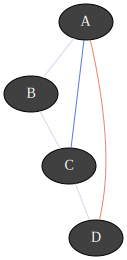

False positives :  1
False negatives :  1
Normalized Hamming distance :  0.3333333333333333


In [133]:
importlib.reload(mnl)
gum.config.reset() # back to default
mn2=gum.MarkovNet(mn_losange)
mn2.addFactor({'A','C'})
mn2.eraseFactor({'A','D'})
gnb.sideBySide(gnb.getMN(mn_losange,view="factorgraph",size="2"),
              gnb.getMN(mn2,view="factorgraph",size="2"))
printCompareMNStructure(mn_losange,mn2)

### Comparaison des paramètres

In [134]:
importlib.reload(mnl)
gum.config.reset() # back to default
mn2=gum.MarkovNet(mn_losange)
mn2.factor({'D','A'})[{}]=[[120,1],[1,100]]
gnb.sideBySide(gnb.getMN(mn2,view="factorgraph",size="2"),
              gnb.getInference(mn2,size="2"))
printCompareMNParameters(mn_losange,mn2)

G <!-- A --> A A <!-- B --> B B <!-- C --> C C <!-- D --> D D <!-- f1#2 --> f1#2 <!-- f1#2--B --> f1#2--B <!-- f1#2--C --> f1#2--C <!-- f0#3 --> f0#3 <!-- f0#3--A --> f0#3--A <!-- f0#3--D --> f0#3--D <!-- f0#1 --> f0#1 <!-- f0#1--A --> f0#1--A <!-- f0#1--B --> f0#1--B <!-- f2#3 --> f2#3 <!-- f2#3--C --> f2#3--C <!-- f2#3--D --> f2#3--D


KL Distance :  0.004006030139272818
Maximum Probability Distance :  0.026718711042091448


### Comparer la structure et les paramètres

Starting structure learning
Structure learned
Starting parameters learning
Sum Gradient  79704.49860742857
Step size :  0.15
Sum Gradient  69151.99900412711
Step size :  0.15
Sum Gradient  59962.268617992486
Step size :  0.15
Sum Gradient  52008.21558962092
Step size :  0.15
Sum Gradient  45028.76001661835
Step size :  0.15
Sum Gradient  38942.9691304769
Step size :  0.15
Sum Gradient  33589.70275487777
Step size :  0.15
Sum Gradient  28848.573095269294
Step size :  0.15
Sum Gradient  24432.21421575457
Step size :  0.15
Sum Gradient  20493.15205468718
Step size :  0.15
Sum Gradient  16806.229258729316
Step size :  0.15
Sum Gradient  13178.211401760285
Step size :  0.15
Sum Gradient  9956.056735166932
Step size :  0.15
Sum Gradient  7195.986710754407
Step size :  0.15
Sum Gradient  4732.375709559308
Step size :  0.15
Parameters learned
STRUCTURE COMPARISON : 


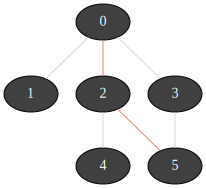

False positives :  0
False negatives :  2
Normalized Hamming distance :  0.13333333333333333

PARAMETERS COMPARISON : 
KL Distance :  0.3619189263737213
Maximum Probability Distance :  0.014389243701561095


In [135]:
importlib.reload(mnl)
template=gum.MarkovNet(mn)
for factor in template.factors():
    template.eraseFactor(factor)
learnedMN=mnl.learnMN(template,"./samples/sampleMN"+str(sampleNB)+".csv",mnl.GSMN,thresholdStatisticalTest=0.005,maxIt=15,step=0.15,display=True)
compareMN(mn,learnedMN)

# Évaluation des algorithmes

### Évaluation de la descente de gradient pour l'apprentissage de paramètres

In [ ]:
#très long !
importlib.reload(mnl)
threshold=0.0001
sampleNBs=[1000]
for sampleNB in sampleNBs:
    for node in np.linspace(8,8,1):
        node=int(node)
        listEdges=[7,8,9,10]
        for edges in listEdges:
            edges=str(edges)
            result=[]
            for graphNB in range(100):
                mn=gum.MarkovNet()
                file="_"+str(graphNB)+".uai"
                mn.loadUAI("./database_param/graph/Nodes"+str(node)+"/Edges"+edges+"/graph"+file)
                forgottenMn=gum.MarkovNet(mn)
                forgottenMn.generateFactors()
                for factor in forgottenMn.factors():
                    for Ifactor in forgottenMn.factor(factor).loopIn():
                        forgottenMn.factor(factor)[Ifactor]=max(forgottenMn.factor(factor)[Ifactor],0.001)
                KLrandom=mnl.compareMNParametersKLDistance(mn,forgottenMn)
                MaxPDistRandom=mnl.compareMNParametersMaxProbabilityDistance(mn,forgottenMn)
                df=pd.read_csv("./database_param/samples/Nodes"+str(node)+"/Edges"+edges+"/sample_"+str(graphNB)+".csv", dtype=str)
                start=time.time()
                mnl.learnParameters(forgottenMn,df,maxIt=15,step=0.15,stepDiscount=0.9,display=False)
                t=time.time()-start
                falsePositives,falseNegatives,NHD=mnl.compareMNStructure(mn,learnedMn)
                result.append({'KL':mnl.compareMNParametersKLDistance(mn,forgottenMn),
                               'Max P Dist':mnl.compareMNParametersMaxProbabilityDistance(mn,forgottenMn),
                               'Time':t,
                               'KL random':KLrandom,
                               'Max P Dist random':MaxPDistRandom})
                print("./database_param/samples/Nodes"+str(node)+"/Edges"+edges+"/sample_"+str(graphNB)+".csv","  : Done")
            outdir = "./database_param/result/Nodes"+str(node)+"/Edges"+edges
            path=Path(outdir)
            path.mkdir(parents=True, exist_ok=True)
            df = pd.DataFrame(data=result)
            df.to_csv("./database_param/result/Nodes"+str(node)+"/Edges"+edges+"/result_gradient_"+str(sampleNB)+".csv",index_label="MN number")
            print("Done for nodes  ",node,"  and edges ",edges)

In [136]:
importlib.reload(mnl)
sampleNB=1000
mean_KL_xComplexity_gradient=[]
mean_KL_xComplexity_random=[]
mean_maxPDist_xComplexity_gradient=[]
mean_maxPDist_xComplexity_random=[]
mean_time_xComplexity_gradient=[]
node=8
for edges in [7,8,9,10]:
    df=pd.read_csv("./database_param/result/Nodes"+str(node)+"/Edges"+str(edges)+"/result_gradient_"+str(sampleNB)+".csv")
    mean_KL_xComplexity_gradient.append(df["KL"].mean())
    mean_KL_xComplexity_random.append(df["KL random"].mean())
    mean_maxPDist_xComplexity_gradient.append(df["Max P Dist"].mean())
    mean_maxPDist_xComplexity_random.append(df["Max P Dist random"].mean())
    mean_time_xComplexity_gradient.append(df["Time"].mean())

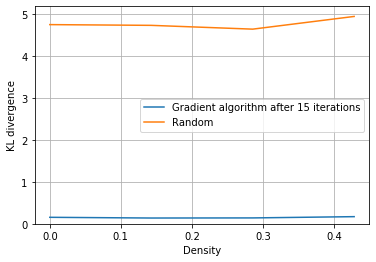

In [137]:
plt.plot([0,1/7,2/7,3/7],mean_KL_xComplexity_gradient,label="Gradient algorithm after 15 iterations")
plt.plot([0,1/7,2/7,3/7],mean_KL_xComplexity_random,label="Random")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Density")
plt.ylabel("KL divergence")
plt.show()

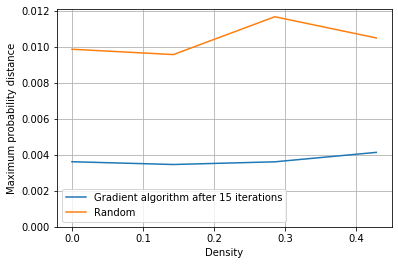

In [138]:
plt.plot([0,1/7,2/7,3/7],mean_maxPDist_xComplexity_gradient,label="Gradient algorithm after 15 iterations")
plt.plot([0,1/7,2/7,3/7],mean_maxPDist_xComplexity_random,label="Random")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Density")
plt.ylabel("Maximum probability distance")
plt.show()

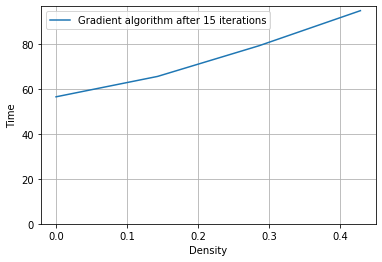

In [139]:
plt.plot([0,1/7,2/7,3/7],mean_time_xComplexity_gradient,label="Gradient algorithm after 15 iterations")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Density")
plt.ylabel("Time")
plt.show()

### Évaluation de l'algorithme GSMN

In [49]:
#très long !
importlib.reload(mnl)
threshold=0.0001
sampleNBs=[10000]
for sampleNB in sampleNBs:
    for node in np.linspace(10,70,7):
        node=int(node)
        for complexity in np.linspace(0,0.5,11):
            edges=str(int((node-1)*complexity+node-1))
            result=[]
            for graphNB in range(100):
                mn=gum.MarkovNet()
                file="_"+str(graphNB)+".uai"
                mn.loadUAI("./database/graph/Nodes"+str(node)+"/Edges"+edges+"/graph"+file)
                template=gum.MarkovNet(mn)
                for factor in template.factors():
                    template.eraseFactor(factor)
                file="_"+str(graphNB)+".csv"
                start=time.time()
                learnedMn=mnl.GSMN(template,"./database/samples/Nodes"+str(node)+"/Edges"+edges+"/sample"+file,threshold)
                t=time.time()-start
                falsePositives,falseNegatives,NHD=mnl.compareMNStructure(mn,learnedMn)
                result.append({'False positives':len(falsePositives),'False Negatives':len(falseNegatives),'Time':t,'NHD':NHD})
            outdir = "./database/result/Nodes"+str(node)+"/Edges"+edges
            path=Path(outdir)
            path.mkdir(parents=True, exist_ok=True)
            df = pd.DataFrame(data=result)
            df.to_csv("./database/result/Nodes"+str(node)+"/Edges"+edges+"/result_GSMN_"+str(sampleNB)+".csv",index_label="MN number")
            print("Done for nodes  ",node,"  and complexity ",complexity)

Done for nodes   10   and complexity  0.0
Done for nodes   10   and complexity  0.05
Done for nodes   10   and complexity  0.1
Done for nodes   10   and complexity  0.15000000000000002
Done for nodes   10   and complexity  0.2
Done for nodes   10   and complexity  0.25
Done for nodes   10   and complexity  0.30000000000000004
Done for nodes   10   and complexity  0.35000000000000003
Done for nodes   10   and complexity  0.4
Done for nodes   10   and complexity  0.45
Done for nodes   10   and complexity  0.5
Done for nodes   20   and complexity  0.0
Done for nodes   20   and complexity  0.05
Done for nodes   20   and complexity  0.1
Done for nodes   20   and complexity  0.15000000000000002
Done for nodes   20   and complexity  0.2
Done for nodes   20   and complexity  0.25
Done for nodes   20   and complexity  0.30000000000000004
Done for nodes   20   and complexity  0.35000000000000003
Done for nodes   20   and complexity  0.4
Done for nodes   20   and complexity  0.45
Done for nodes  

In [140]:
importlib.reload(mnl)
sampleNB=10000
mean_NHD_xNode_GSMN=[]
mean_time_xNode_GSMN=[]
mean_fP_xNode_GSMN=[]
mean_fN_xNode_GSMN=[]
for node in np.linspace(10,70,7):
    node=int(node)
    df=pd.DataFrame()
    for complexity in np.linspace(0,0.5,11):
        edges=str(int((node-1)*complexity+node-1))
        df_tmp=pd.read_csv("./database/result/Nodes"+str(node)+"/Edges"+edges+"/result_GSMN_"+str(sampleNB)+".csv",usecols=[1,2,3,4])
        df=pd.concat([df,df_tmp])
    mean_NHD_xNode_GSMN.append(df["NHD"].mean())
    mean_time_xNode_GSMN.append(df["Time"].mean())
    mean_fP_xNode_GSMN.append(df["False positives"].mean())
    mean_fN_xNode_GSMN.append(df["False Negatives"].mean())

In [141]:
importlib.reload(mnl)
sampleNB=10000
mean_NHD_xComplexity_GSMN=[]
mean_time_xComplexity_GSMN=[]
for complexity in np.linspace(0,0.5,11):
    df=pd.DataFrame()
    for node in np.linspace(10,70,7):
        node=int(node)
        edges=str(int((node-1)*complexity+node-1))
        df_tmp=pd.read_csv("./database/result/Nodes"+str(node)+"/Edges"+edges+"/result_GSMN_"+str(sampleNB)+".csv",usecols=[1,2,3,4])
        df=pd.concat([df,df_tmp])
    mean_NHD_xComplexity_GSMN.append(df["NHD"].mean())
    mean_time_xComplexity_GSMN.append(df["Time"].mean())

### Évaluation de l'algorithme GSMNStar

In [50]:
#très long !
importlib.reload(mnl)
threshold=0.0001
sampleNBs=[10000]
for node in np.linspace(10,70,7):
    node=int(node)
    for complexity in np.linspace(0,0.5,11):
        edges=str(int((node-1)*complexity+node-1))
        result=[]
        for graphNB in range(100):
            mn=gum.MarkovNet()
            file="_"+str(graphNB)+".uai"
            mn.loadUAI("./database/graph/Nodes"+str(node)+"/Edges"+edges+"/graph"+file)
            template=gum.MarkovNet(mn)
            for factor in template.factors():
                template.eraseFactor(factor)
            file="_"+str(graphNB)+".csv"
            start=time.time()
            learnedMn=mnl.GSMNStar(template,"./database/samples/Nodes"+str(node)+"/Edges"+edges+"/sample"+file,threshold)
            t=time.time()-start
            falsePositives,falseNegatives,NHD=mnl.compareMNStructure(mn,learnedMn)
            result.append({'False positives':len(falsePositives),'False Negatives':len(falseNegatives),'Time':t,'NHD':NHD})
        outdir = "./database/result/Nodes"+str(node)+"/Edges"+edges
        path=Path(outdir)
        path.mkdir(parents=True, exist_ok=True)
        df = pd.DataFrame(data=result)
        df.to_csv("./database/result/Nodes"+str(node)+"/Edges"+edges+"/result_GSMNStar_"+str(sampleNB)+".csv",index_label="MN number")
        print("Done for nodes  ",node,"  and complexity ",complexity)

Done for nodes   10   and complexity  0.0
Done for nodes   10   and complexity  0.05
Done for nodes   10   and complexity  0.1
Done for nodes   10   and complexity  0.15000000000000002
Done for nodes   10   and complexity  0.2
Done for nodes   10   and complexity  0.25
Done for nodes   10   and complexity  0.30000000000000004
Done for nodes   10   and complexity  0.35000000000000003
Done for nodes   10   and complexity  0.4
Done for nodes   10   and complexity  0.45
Done for nodes   10   and complexity  0.5
Done for nodes   20   and complexity  0.0
Done for nodes   20   and complexity  0.05
Done for nodes   20   and complexity  0.1
Done for nodes   20   and complexity  0.15000000000000002
Done for nodes   20   and complexity  0.2
Done for nodes   20   and complexity  0.25
Done for nodes   20   and complexity  0.30000000000000004
Done for nodes   20   and complexity  0.35000000000000003
Done for nodes   20   and complexity  0.4
Done for nodes   20   and complexity  0.45
Done for nodes  

In [142]:
importlib.reload(mnl)
sampleNB=10000
mean_NHD_xNode_GSMNStar=[]
mean_time_xNode_GSMNStar=[]
mean_fP_xNode_GSMNStar=[]
mean_fN_xNode_GSMNStar=[]
for node in np.linspace(10,70,7):
    node=int(node)
    df=pd.DataFrame()
    for complexity in np.linspace(0,0.5,11):
        edges=str(int((node-1)*complexity+node-1))
        df_tmp=pd.read_csv("./database/result/Nodes"+str(node)+"/Edges"+edges+"/result_GSMNStar_"+str(sampleNB)+".csv",usecols=[1,2,3,4])
        df=pd.concat([df,df_tmp])
    mean_NHD_xNode_GSMNStar.append(df["NHD"].mean())
    mean_time_xNode_GSMNStar.append(df["Time"].mean())
    mean_fP_xNode_GSMNStar.append(df["False positives"].mean())
    mean_fN_xNode_GSMNStar.append(df["False Negatives"].mean())

In [143]:
importlib.reload(mnl)
sampleNB=10000
mean_NHD_xComplexity_GSMNStar=[]
mean_time_xComplexity_GSMNStar=[]
for complexity in np.linspace(0,0.5,11):
    df=pd.DataFrame()
    for node in np.linspace(10,70,7):
        node=int(node)
        edges=str(int((node-1)*complexity+node-1))
        df_tmp=pd.read_csv("./database/result/Nodes"+str(node)+"/Edges"+edges+"/result_GSMNStar_"+str(sampleNB)+".csv",usecols=[1,2,3,4])
        df=pd.concat([df,df_tmp])
    mean_NHD_xComplexity_GSMNStar.append(df["NHD"].mean())
    mean_time_xComplexity_GSMNStar.append(df["Time"].mean())

### GSMN   VS   GSMNStar

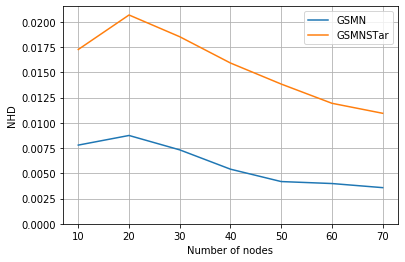

In [144]:
plt.plot(np.linspace(10,70,7),mean_NHD_xNode_GSMN,label="GSMN")
plt.plot(np.linspace(10,70,7),mean_NHD_xNode_GSMNStar,label="GSMNSTar")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("NHD")
plt.show()

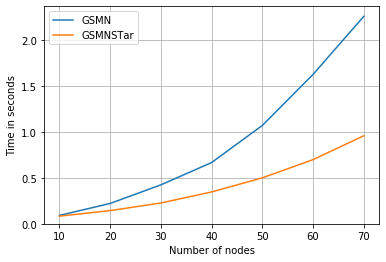

In [145]:
plt.plot(np.linspace(10,70,7),mean_time_xNode_GSMN,label="GSMN")
plt.plot(np.linspace(10,70,7),mean_time_xNode_GSMNStar,label="GSMNSTar")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("Time in seconds")
plt.show()

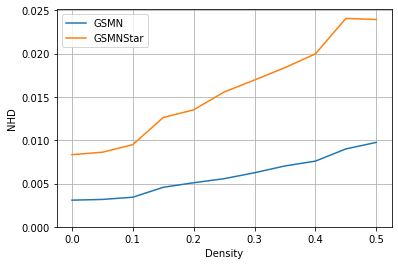

In [146]:
plt.plot(np.linspace(0,0.5,11),mean_NHD_xComplexity_GSMN,label="GSMN")
plt.plot(np.linspace(0,0.5,11),mean_NHD_xComplexity_GSMNStar,label="GSMNStar")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Density")
plt.ylabel("NHD")
plt.show()

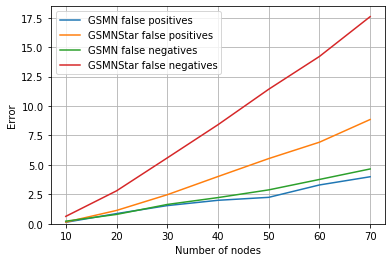

In [147]:
plt.plot(np.linspace(10,70,7),mean_fP_xNode_GSMN,label="GSMN false positives")
plt.plot(np.linspace(10,70,7),mean_fP_xNode_GSMNStar,label="GSMNStar false positives")
plt.plot(np.linspace(10,70,7),mean_fN_xNode_GSMN,label="GSMN false negatives")
plt.plot(np.linspace(10,70,7),mean_fN_xNode_GSMNStar,label="GSMNStar false negatives")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("Error")
plt.show()

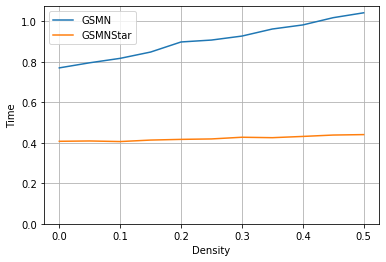

In [148]:
plt.plot(np.linspace(0,0.5,11),mean_time_xComplexity_GSMN,label="GSMN")
plt.plot(np.linspace(0,0.5,11),mean_time_xComplexity_GSMNStar,label="GSMNStar")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Density")
plt.ylabel("Time")
plt.show()

### Apprentissage de la structure puis des paramètres

In [83]:
#très long !
importlib.reload(mnl)
threshold=0.0001
sampleNBs=[1000]
for sampleNB in sampleNBs:
    for node in np.linspace(8,8,1):
        node=int(node)
        listEdges=[7,8,9,10]
        for edges in listEdges:
            edges=str(edges)
            result=[]
            for graphNB in range(100):
                mn=gum.MarkovNet()
                file="_"+str(graphNB)+".uai"
                mn.loadUAI("./database_param/graph/Nodes"+str(node)+"/Edges"+edges+"/graph"+file)
                template=gum.MarkovNet(mn)
                for factor in template.factors():
                    template.eraseFactor(factor)
                file="_"+str(graphNB)+".csv"
                forgottenMn=mnl.GSMN(template,"./database_param/samples/Nodes"+str(node)+"/Edges"+edges+"/sample"+file,threshold)
                forgottenMn.generateFactors()
                for factor in forgottenMn.factors():
                    for Ifactor in forgottenMn.factor(factor).loopIn():
                        forgottenMn.factor(factor)[Ifactor]=max(forgottenMn.factor(factor)[Ifactor],0.001)
                KLrandom=mnl.compareMNParametersKLDistance(mn,forgottenMn)
                MaxPDistRandom=mnl.compareMNParametersMaxProbabilityDistance(mn,forgottenMn)
                df=pd.read_csv("./database_param/samples/Nodes"+str(node)+"/Edges"+edges+"/sample_"+str(graphNB)+".csv", dtype=str)
                start=time.time()
                mnl.learnParameters(forgottenMn,df,maxIt=15,step=0.15,stepDiscount=0.9,display=False)
                t=time.time()-start
                falsePositives,falseNegatives,NHD=mnl.compareMNStructure(mn,learnedMn)
                result.append({'KL':mnl.compareMNParametersKLDistance(mn,forgottenMn),
                               'Max P Dist':mnl.compareMNParametersMaxProbabilityDistance(mn,forgottenMn),
                               'Time':time.time()-start,
                               'KL random':KLrandom,
                               'Max P Dist random':MaxPDistRandom})
                print("./database_param/samples/Nodes"+str(node)+"/Edges"+edges+"/sample_"+str(graphNB)+".csv","  : Done")
            outdir = "./database_param/result_bothlearning/Nodes"+str(node)+"/Edges"+edges
            path=Path(outdir)
            path.mkdir(parents=True, exist_ok=True)
            df = pd.DataFrame(data=result)
            df.to_csv("./database_param/result_bothlearning/Nodes"+str(node)+"/Edges"+edges+"/result_gradient_"+str(sampleNB)+".csv",index_label="MN number")
            print("Done for nodes  ",node,"  and edges ",edges)

./database_param/samples/Nodes8/Edges8/sample_0.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_1.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_2.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_3.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_4.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_5.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_6.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_7.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_8.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_9.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_10.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_11.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_12.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_13.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_14.csv   : Done
./database_param/samples/Nodes8/Edges8/sample_15.csv   : Done
./database_param/s

./database_param/samples/Nodes8/Edges9/sample_32.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_33.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_34.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_35.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_36.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_37.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_38.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_39.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_40.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_41.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_42.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_43.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_44.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_45.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_46.csv   : Done
./database_param/samples/Nodes8/Edges9/sample_47.csv   : Done
./databa

./database_param/samples/Nodes8/Edges10/sample_63.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_64.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_65.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_66.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_67.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_68.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_69.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_70.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_71.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_72.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_73.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_74.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_75.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_76.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_77.csv   : Done
./database_param/samples/Nodes8/Edges10/sample_78.csv  

In [149]:
importlib.reload(mnl)
sampleNB=1000
mean_KL_xComplexity_gradient=[]
mean_KL_xComplexity_gradientandGSMN=[]
node=8
for edges in [7,8,9,10]:
    df=pd.read_csv("./database_param/result/Nodes"+str(node)+"/Edges"+str(edges)+"/result_gradient_"+str(sampleNB)+".csv")
    df2=pd.read_csv("./database_param/result_bothlearning/Nodes"+str(node)+"/Edges"+str(edges)+"/result_gradient_"+str(sampleNB)+".csv")
    mean_KL_xComplexity_gradient.append(df["KL"].mean())
    mean_KL_xComplexity_gradientandGSMN.append(df2["KL"].mean())

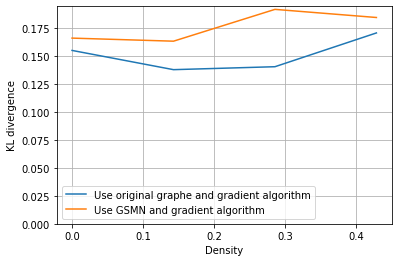

In [150]:
plt.plot([0,1/7,2/7,3/7],mean_KL_xComplexity_gradient,label="Use original graphe and gradient algorithm")
plt.plot([0,1/7,2/7,3/7],mean_KL_xComplexity_gradientandGSMN,label="Use GSMN and gradient algorithm")
axes = plt.gca()
axes.set_ylim([0,None])
plt.legend()
plt.grid()
plt.xlabel("Density")
plt.ylabel("KL divergence")
plt.show()